# Epidemic mitigation project

For question 3 we reuse the tutorial environment

### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
!pip install gym==0.26.2

In [2]:
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
import seaborn as sns

SEED = 69

%matplotlib inline

In [3]:
# Some code to make the picture a bit nicer for the report
SAVE_REPORT = False
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
# does need cm-super, dvipng and latex to be installed
if SAVE_REPORT:
        plt.rcParams.update(tex_fonts)

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim


In [4]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

#### Question 4.2.a Implementing the DQN agent, with multi-action

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
SCALE = 100

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': a[0] == 1, 
        'isolation': a[1] == 1, 
        'hospital': a[2] == 1, 
        'vaccinate': a[3] == 1,
    }
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obvSpace = torch.Tensor(np.stack((infected, dead))).to(device).unsqueeze(0)
    return obvSpace

In [7]:
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"Number cities: {dyn.n_cities} and env_step_length: {dyn.env_step_length}")
print(f"sampled action : {action_space.sample()}")
example_obs = observation_space.sample()
print(f"Sampled observation (shape {example_obs.shape}) first dimension is infected & dead")

Number cities: 9 and env_step_length: 7
sampled action : [0 0 1 1]
Sampled observation (shape (2, 9, 7)) first dimension is infected & dead


In [8]:
env = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor
        )

#### 3.a) implementing Deep Q-Learning

In [9]:
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import seaborn as sns
import pandas as pd

random.seed(SEED)

In [10]:
# Parameters given by the assignment
# TODO maybe try some hyperparameter tuning after we know the DQN works
LR = 10**-5
DF = 0.9
MS = 20_000
BS = 2048

update_every = 5 # episodes
episodes = 500
average_over = 3

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(n_observations, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        # TODO maybe 1/4 scale?
        x = x**0.25
        x = self.flatten(x)
        x = F.relu(self.input(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

In [13]:
# Utility function used later
def flatten(l):
    return [item for sublist in l for item in sublist]

In [14]:
# Runs the agent over one episode
def run_episode(agent, env, seed=None):
    finished = False
    if seed is None:
        obs, _ = env.reset()
    else:
        obs, _ = env.reset(seed)
    rewards = []
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        # Meaning also the log info is per week
        new_obs, R, finished, _ = env.step(action)
        # Log this step
        #deaths.append(info.total.dead)
        rewards.append(R)
        #log.append(info) # save the information dict for logging
        if seed is None:
            # If terminal => no next state exits
            next_obs = None if finished else new_obs
            # Save to replay buffer
            agent.memory.push(obs, action, next_obs, R)
            # Move to the next state
            obs = next_obs
            # Optimize the model
            agent.optimize_model()
            
    return np.sum([r.numpy()[0] for r in rewards])

In [15]:
best_eval_reward = -np.inf

def evaluate_agent(agent, env, seed, eval_episodes=20, save_best=True):
    last_eps = agent.epsilon
    agent.epsilon = 0
    eval_rewards = []
    for i in range(eval_episodes):
        eval_rewards.append(run_episode(agent, env, seed+i))
    mean_eval_reward = np.mean(eval_rewards)
    agent.epsilon = last_eps
    # check if this is the best reward and if so save the model
    global best_eval_reward
    if save_best and mean_eval_reward > best_eval_reward:
        best_eval_reward = mean_eval_reward
        agent.save_model(savepath="Q42_best_model.mdl")
        print(f"Best model updated with mean eval reward: {mean_eval_reward:.2f}")
    return mean_eval_reward

In [16]:
class DQNagent(Agent):
    def __init__(self,  env:Env, eps=0.7):
        self.env = env
        self.n_observations = spaces.utils.flatdim(env.observation_space)
        self.n_actions = 4*2
        print(f"Creating a DQNagent with n_obs: {self.n_observations} and n_act: {self.n_actions}")
        self.dqnQtheta = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat.load_state_dict(self.dqnQtheta.state_dict())
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqnQtheta.parameters(), lr=LR, amsgrad=True)
        self.epsilon = eps

    def load_model(self, savepath):
        loaded_state_dict = torch.load(savepath)    
        self.dqnQtheta.load_state_dict(loaded_state_dict)
        self.dqnQhat.load_state_dict(loaded_state_dict)

    def save_model(self, savepath):
        torch.save(self.dqnQtheta.state_dict(), savepath)
        
    # Following alg. 1 in https://arxiv.org/pdf/1312.5602.pdf
    def optimize_model(self,):
        # Heavily based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        if len(self.memory) < BS:
            return
        transitions = self.memory.sample(BS)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        #print(f"non_final_mask: {non_final_mask.shape}") #torch.Size([BS])
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action).to(device).view(-1, 4, 1) # should have the form of (BS, 4, 1)
        reward_batch = torch.cat(batch.reward).to(device).squeeze() # should have the form of (BS)

        # Compute  Q_sigma(sj, aj) for all states.
        state_action_values = self.dqnQtheta(state_batch).view(-1, 4, 2) # Shape (BS, 4, 2)
        state_action_values = state_action_values.gather(2, action_batch) # Form of (BS, 4, 1)
        # Q value is defined as the sum of half of the neurons, namely those chosen by the action
        state_action_values = state_action_values.squeeze().sum(dim=1) # Form of (BS) (we sum over the 4 chosen actions)

        # Compute rj + DF * max_a' Q_hat(sj+1, a') for all non-final states,
        # for all final states values are 0
        next_state_values = torch.zeros(BS, device=device) # (BS)
        with torch.no_grad():
            #OG: next_state_values[non_final_mask] = self.dqnQhat(non_final_next_states).max(1)[0]
            all_q_values = self.dqnQhat(non_final_next_states).view(-1, 4, 2) # (BS, 4, 2)
            # for each neuron pair in all_q_values, take the sum over the max of each two paired neurons
            max_pair_q_values = all_q_values.max(2)[0].sum(dim=1) # (BS, 1)
            next_state_values[non_final_mask] = max_pair_q_values.squeeze() #(BS)
        expected_state_action_values = reward_batch + (DF * next_state_values) # (BS)

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model, where we update Q_0 & Q_hat at the same time
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.dqnQtheta.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        torch.manual_seed(SEED)
        torch.use_deterministic_algorithms(True)
        pass
    
    def act(self, obs):
        # eps greedy choosing
        if random.random() < self.epsilon:
            # Exploitation
            with torch.no_grad():
                # The unmitigated agent always takes the same action, i.e. do nothing
                multi_pairs = self.dqnQtheta(obs.unsqueeze(0)).view(4,2) # flatten not necessary bc of nn.Flatten
                # multi_pairs contains 4 * 2 neuron pairs, we need to choose for each pair the higher one
                res = multi_pairs.max(1)[1]
                return res
        else:
            # Exploration
            return torch.tensor(self.env.action_space.sample(), device=device, dtype=torch.long)

In [17]:
def run_simulation(agent,env,seed, eps_0=0.7, eps_min=0.2):
    """ Run the simulation """
    training_trace = []
    eval_trace = []
    for i in range(episodes):
        print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%)", end="\r")
        agent.epsilon = max(eps_0*(episodes-i)/episodes, eps_min)
        reward = run_episode(agent, env)
        training_trace.append(reward)
        if i % update_every == 0:
            # Update the target network fully, copying all weights and biases
            agent.dqnQhat.load_state_dict(agent.dqnQtheta.state_dict())
        if (i % 50 == 0 or i == episodes-1) and i != 0:
            # run eval 20 episodes average with epsilon of 0
            mean_eval_reward = evaluate_agent(agent, env, seed, eval_episodes=20)
            print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%) - eval reward: {mean_eval_reward:.2f}")
            eval_trace.append(mean_eval_reward)
    
    return training_trace, eval_trace

# Eval trace averaged over n runs, training_trace can be used together
training_trace, eval_trace = list(zip(*[run_simulation(DQNagent(env),env,SEED) for _ in range(average_over)]))
training_trace = flatten(training_trace)
eval_trace = np.mean(eval_trace, axis=0)

Creating a DQNagent with n_obs: 126 and n_act: 8
Best model updated with mean eval reward: -135.37
Episode  51/500 (10.00%) - eval reward: -135.37
Episode 101/500 (20.00%) - eval reward: -141.46
Best model updated with mean eval reward: -112.83
Episode 151/500 (30.00%) - eval reward: -112.83
Episode 201/500 (40.00%) - eval reward: -133.04
Episode 251/500 (50.00%) - eval reward: -126.62
Episode 301/500 (60.00%) - eval reward: -124.79
Best model updated with mean eval reward: -110.67
Episode 351/500 (70.00%) - eval reward: -110.67
Episode 401/500 (80.00%) - eval reward: -129.78
Episode 451/500 (90.00%) - eval reward: -136.55
Episode 500/500 (99.80%) - eval reward: -140.91
Creating a DQNagent with n_obs: 126 and n_act: 8
Episode  51/500 (10.00%) - eval reward: -143.69
Episode 101/500 (20.00%) - eval reward: -126.68
Episode 151/500 (30.00%) - eval reward: -153.56
Episode 201/500 (40.00%) - eval reward: -135.68
Episode 251/500 (50.00%) - eval reward: -135.59
Episode 301/500 (60.00%) - eval 

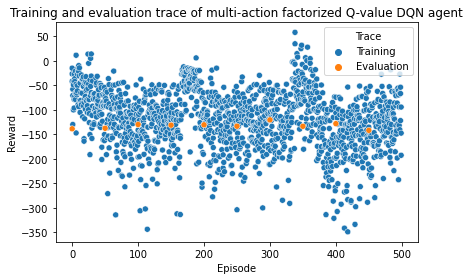

In [18]:
combined_q42 = pd.concat([
    pd.DataFrame({
        "Episode": flatten([[i]*average_over for i in range(int(len(training_trace)/average_over))]),
        "Reward": training_trace,
        "Trace": ["Training" for _ in range(len(training_trace))],
        "Model": ["Factor" for _ in range(len(training_trace))]
    }),
    pd.DataFrame({
        "Episode": [50 * i for i in range(len(eval_trace))],
        "Reward": eval_trace,
        "Trace": ["Evaluation" for _ in range(len(eval_trace))],
        "Model": ["Factor" for _ in range(len(eval_trace))]
    })
])
sns.scatterplot(data=combined_q42, x="Episode", y="Reward", hue="Trace")
plt.title("Training and evaluation trace of multi-action factorized Q-value DQN agent")
plt.tight_layout()
plt.show()

In [19]:
# Plot this policy learning agains Q41
# TODO load results from Q4.1
combined = pd.concat([combined_q42, combined_q41])
sns.scatterplot(data=combined, x="Episode", y="Reward", hue="Trace", style="Model")
plt.title("Training & eval. trace of DQN agent with diff. exploration.")
plt.tight_layout()
plt.show()

NameError: name 'combined_q41' is not defined

TODO: Does your agent sucessfully learn a policy?

Record three example episodes with best policy and plot one of them.

In [20]:
agent = DQNagent(env)
agent.load_model("Q42_best_model.mdl")

def run_simulation(agent,env,seed):
    """ Run the simulation """
    log = []
    finished = False
    obs, info = env.reset(seed)
    deaths = []
    rewards = []
    agent.reset()
    agent.epsilon = 0
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        # Meaning also the log info is per week
        obs, R, finished, info = env.step(action)
        deaths.append(info.total.dead)
        rewards.append(R)
        log.append(info) # save the information dict for logging

    """ Parse the logs """
    deaths = np.array(deaths)
    rewards = np.array([r.numpy()[0] for r in rewards])
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return deaths, rewards, total, cities, actions

three_example_episodes = [run_simulation(agent,env,SEED+i) for i in range(3)]

Creating a DQNagent with n_obs: 126 and n_act: 8


In [26]:
# Choose one of the example episodes and plot the results
deaths, rewards, total, cities, actions = three_example_episodes[1]

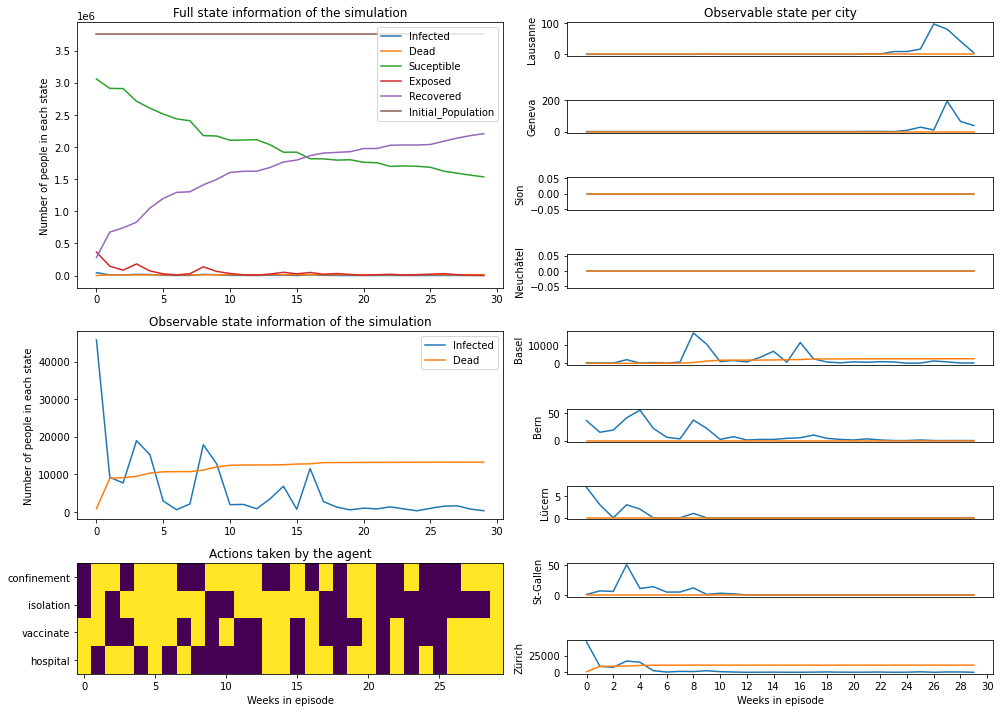

In [27]:
# Single plot
size = set_size(700) if SAVE_REPORT else (14, 10)
fig = plt.figure(figsize=size)
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend([t.title() for t in total.keys()])
ax_leftstate.set_title('Full state information of the simulation')
ax_leftstate.set_ylabel('Number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['Infected','Dead'])
ax_leftobs.set_title('Observable state information of the simulation')
ax_leftobs.set_ylabel('Number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions taken by the agent')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Weeks in episode')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('Weeks in episode')
ax_right['Zürich'].xaxis.set_major_locator(ticker.MultipleLocator(2.000))
ax_right['Lausanne'].set_title('Observable state per city')

fig.tight_layout()
fig.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q3-a-complete.png', dpi=300)
else:
    plt.show()

TODO: Interpret this policy.

#### Multiple simulations (Question 4.2.b)
Running a suimulation of 50 enviroments with the DQN agent

In [23]:
def simulation(agent,env,n):
    info = []
    for i in range(n):
        # Run the agent with seed i, returns deaths, rewards, total, cities, actions
        info.append(run_simulation(agent,env,i))
    return info
info = simulation(agent,env,50)

In [24]:
# process simulations
conf_days = [np.sum(c[4]["confinement"])*7 for c in info]
rewards = [np.mean(c[1]) for c in info]
deaths = [d[0][-1] for d in info] 

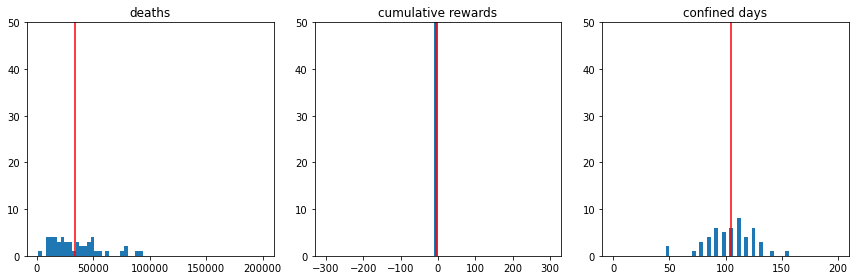

Average death number: 33783.18
Average cumulative reward: -4.467695713043213
Average number of confined days: 104.44


In [25]:
""" As it is deterministic we really don't need to get anything else than deaths and rewards """
""" Plot example """
fig, ax = plt.subplots(1,3,figsize=(12,4))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(conf_days)}')

TODO: How does this multi-action policy compare to the toggled policy?

#### Question 4.2.c

TODO: What assumptions does the use of such a factorized-Q-value policy make on the action space?